<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

## Task 2: Setup your TensorFlow and Colab Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Install TensorFlow and TensorFlow Model Garden

In [7]:
import tensorflow as tf
print(tf.version.VERSION)

2.9.2


In [8]:
#!pip install -q tensorflow==2.3.0

In [9]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [10]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [11]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [12]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",compression='zip',low_memory=False)

In [14]:
df.shape

(1306122, 3)

<AxesSubplot: title={'center': 'target distribution'}, ylabel='Frequency'>

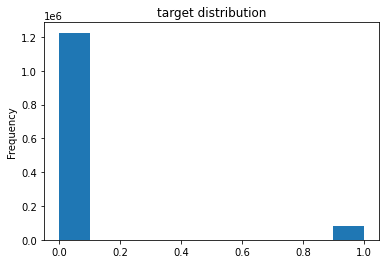

In [15]:
df.target.plot(kind='hist',title='target distribution')

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [16]:
train_df,remaining= train_test_split(df,random_state=42,train_size=0.0075,stratify=df.target.values)
valid_df,_=train_test_split(remaining,random_state=42,train_size=0.00075,stratify=remaining.target.values)
train_df.shape,valid_df.shape

((9795, 3), (972, 3))

In [17]:
with tf.device('/cpu:0'):
  train_data= tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,train_df['target'].values))
  valid_data= tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,valid_df['target'].values))
  for text,label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [18]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
label_list=[0,1]
 # maximum length of (token) input sequences
max_seq_length=128
train_batch_size=32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)
vocab_file= bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
tokenizer= tokenization.FullTokenizer(vocab_file,do_lower_case)



In [19]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [20]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [21]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example= classifier_data_lib.InputExample(guid=None , text_a=text.numpy(),text_b=None,label=label.numpy())
  feature= classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
  return(feature.input_ids,feature.input_mask,feature.segment_ids,feature.label_id)
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [22]:
def to_feature_map(text, label):
  input_ids,input_mask,segment_ids,label_id =tf.py_function(to_feature,inp=[text,label],Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x={
      'input_word_ids':input_ids,
     'input_mask':input_mask,
     'input_type_ids':segment_ids
  }
  return (x ,label_id)
  

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [23]:
with tf.device('/cpu:0'):

  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32,drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data=(valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [24]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [25]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [26]:
# Building the model
def create_model():
  input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32, name="input_word_ids")
  input_mask=tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32, name="input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32, name="input_type_ids")
  pooled_output,sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])
  drop=tf.keras.layers.Dropout(0.4)(pooled_output)
  output=tf.keras.layers.Dense(1,activation='sigmoid',name="output")(drop)
  model= tf.keras.Model(
      inputs={
          'input_word_ids':input_word_ids,
          'input_mask':input_mask,
          'input_type_ids':input_type_ids
      },
      outputs=output)
  return model 

## Task 10: Fine-Tune BERT for Text Classification

In [27]:
model= create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

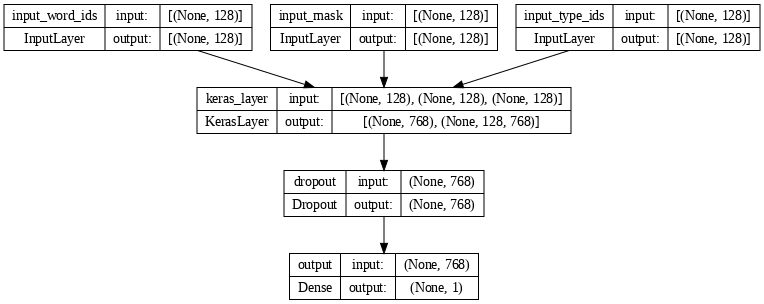

In [28]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=72)

In [ ]:
# Train model
epochs=2
history=model.fit(train_data,validation_data=valid_data,epochs=epochs,verbose=1)


Epoch 1/2
  1/306 [..............................] - ETA: 4:57:33 - loss: 0.0759 - binary_accuracy: 0.9062

## Task 11: Evaluate the BERT Text Classification Model

In [30]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [1]:
plot_graphs(history,'loss')

NameError: ignored

In [2]:
plot_graphs(history,'binary_accuracy')

NameError: ignored

In [ ]:
sample_example=["sentence1","sentence2", ...]
test_data=tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data=(test_data.map(to_feature_map).batch(1))
preds=model.predict(test_data)
threshold= 0.65 #between 0 and 1
['insincere'if pred >=threshold else 'sincere'for pred in preds]